In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV
%ls
!pip install pyunpack
!pip install patool

/content/drive/MyDrive/Colab Notebooks/CV
checkpoints/  dataset/  dataset.rar


In [ ]:
# write a efficientNet model to classify adoption rate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import glob
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os
import seaborn as sns


In [ ]:
# Archive('dataset.rar').extractall('/content/drive/MyDrive/Colab Notebooks/CV/')

In [ ]:
INPUT_SHAPE = (224,224,3)
IMAGE_SIZE = (224, 224)
NUM_CLASS = 5 # [0,1,2,3,4]
DEST_TRAIN_IMAGE_PATH = "dataset/train"
DEST_TEST_IMAGE_PATH = "dataset/test"

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def efficientNet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = img_augmentation(inputs)
    eff_model = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=0.2)(x)
    x = layers.BatchNormalization()(eff_model)
    x = layers.GlobalAveragePooling2D(name="avg_pool_final")(x)
    x = layers.Dense(256, activation="relu", name="feature_extractor")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()
    return model

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/CV
%ls

/content/drive/MyDrive/Colab Notebooks/CV
checkpoints/  dataset/  dataset.rar


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of images')

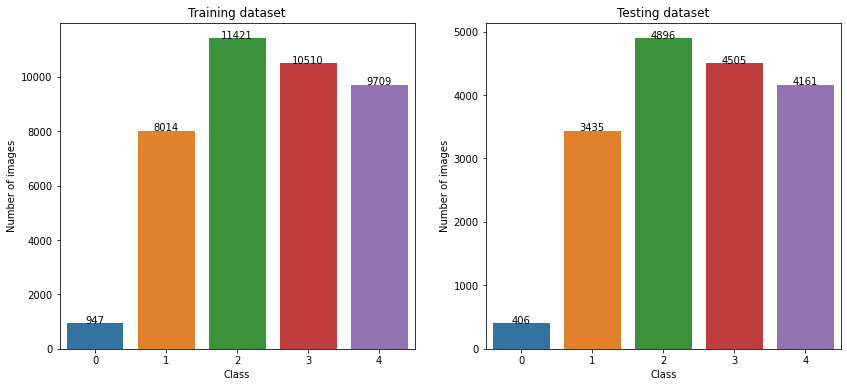

In [ ]:
classes_train = [0,1,2,3,4]
class_train_images = []
for class_name in os.listdir(DEST_TRAIN_IMAGE_PATH):
    image_total = len(os.listdir(os.path.join(DEST_TRAIN_IMAGE_PATH, class_name)))
    class_train_images.append(image_total)

classes_test = [0,1,2,3,4]
class_test_images = []
for class_name in os.listdir(DEST_TEST_IMAGE_PATH):
    image_total = len(os.listdir(os.path.join(DEST_TEST_IMAGE_PATH, class_name)))
    class_test_images.append(image_total)
    
figure, ax = plt.subplots(1,2, figsize=(14,6))
train_sns = sns.barplot(classes_train, class_train_images, ax=ax[0])
for i, class_name in enumerate(classes_train):
    train_sns.text(i, class_train_images[i], class_train_images[i], color='black', ha="center")
ax[0].set_title("Training dataset")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of images")
test_sns = sns.barplot(classes_test, class_test_images, ax=ax[1])
for i, class_name in enumerate(classes_test):
    test_sns.text(i, class_test_images[i], class_test_images[i], color='black', ha="center")
ax[1].set_title("Testing dataset")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of images")

In [ ]:
train_ds = image_dataset_from_directory(
    directory="dataset/train",
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=IMAGE_SIZE)

val_ds = image_dataset_from_directory(
    directory='dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=IMAGE_SIZE)

train_ds = train_ds.prefetch(buffer_size=128)
val_ds = val_ds.prefetch(buffer_size=128)

Found 40601 files belonging to 5 classes.
Found 17403 files belonging to 5 classes.


In [ ]:
efficientNetB0_model = efficientNet_model(INPUT_SHAPE, NUM_CLASS)
efficientNetB0_model.fit(train_ds, epochs=1, validation_data=val_ds, verbose=1)
efficientNetB0_model.save('checkpoints/checkpoint-1.h5')

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 1280)        5120      
_________________________________________________________________
avg_pool_final (GlobalAverag (None, 1280)              0         
_________________________________________________________________
feature_extractor (Dense)    (None, 256)               327936    
_________________________________________________________________
pred (Dense)                 (None, 5)              

In [17]:
# reload and retrain previous model
model = keras.models.load_model('checkpoints/checkpoint-20.h5')
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=1)
model.save('checkpoints/checkpoint-25.h5')

Epoch 1/5
635/635 [==============================] - 645s 1s/step - loss: 0.9720 - accuracy: 0.6008 - val_loss: 1.5820 - val_accuracy: 0.4111
Epoch 2/5
635/635 [==============================] - 638s 1s/step - loss: 0.8807 - accuracy: 0.6414 - val_loss: 1.6088 - val_accuracy: 0.4119
Epoch 3/5
635/635 [==============================] - 637s 1s/step - loss: 0.8318 - accuracy: 0.6664 - val_loss: 1.6585 - val_accuracy: 0.4119
Epoch 4/5
635/635 [==============================] - 636s 999ms/step - loss: 0.8057 - accuracy: 0.6779 - val_loss: 1.6667 - val_accuracy: 0.4157
Epoch 5/5
635/635 [==============================] - 637s 1s/step - loss: 0.7764 - accuracy: 0.6920 - val_loss: 1.6900 - val_accuracy: 0.4223


In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="feature_extractor").output
)


In [19]:
image = cv2.imread("dataset/test/0/0a555d688-1.jpg")
image = cv2.resize(image, IMAGE_SIZE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.reshape(image, (1, 224, 224, 3))
features = feature_extractor(image)
print(features)

tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  2.0935256  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.09787618
  0.         0.         0.26675278 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.63479793 0.         0.
  0.46271724 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.      